In [1]:
import glob
import os
import shutil
from datetime import datetime
from PIL import Image 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
RSEED=123

2022-12-04 00:15:39.652629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 00:15:39.829422: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so
I1204 00:15:40.052379109 1458912 ev_epoll1_linux.cc:121]     grpc epoll fd: 69
D1204 00:15:40.052404134 1458912 ev_posix.cc:141]            Using polling engine: epoll1
D1204 00:15:40.052503303 1458912 lb_policy_registry.cc:43]   registering LB policy factory for "grpclb"
D1204 00:15:40.052533359 1458912 lb_policy_registry.cc:43]   registering LB policy factory for "rls_experimental"
D1204 00:15:40.052603663 1458912 lb_policy_registry.cc:43]   registering LB policy factory for "priority_experimental"
D1204 00:15:40

In [3]:
tf.config.list_logical_devices('TPU')

2022-12-04 00:15:42.120952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 00:15:45.896921: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x848cdb0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-12-04 00:15:45.896953: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): TPU, 2a886c8
2022-12-04 00:15:45.896973: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): TPU, 2a886c8
2022-12-04 00:15:45.896980: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): TPU, 2a886c8
2022-12-04 00:15:45.896985: I tensorflow/compiler/xla/service/service.cc:181]   

[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

r device (6): TPU, 2a886c8
2022-12-04 00:15:45.897007: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (7): TPU, 2a886c8


In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [5]:
start_time = datetime.now().strftime('-%Y-%m-%d-%T')

In [6]:
batch_size = 64
buffer_size = 1000
img_height = 240
img_width = 240
scan_channels = 4
output_classes = 5


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
colour_list = ['w', '#d73027', '#91bfdb', '0.8', '#fee090']
cmap = ListedColormap(colour_list)

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]),cmap=cmap)
        plt.axis('off')
    plt.show()
  
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [9]:
images = []
maps = []

train_image_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy_dropbg','train','image_data')
train_map_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy_dropbg','train','map_data')

# Count pixels for sample weight
pixel_counts = [0,0,0,0,0]
for map_file in os.listdir(train_map_dir):

    seg_map = tf.io.read_file(os.path.join(train_map_dir,map_file))
    seg_map = tf.io.decode_png(seg_map, channels=1)
    
    indices,counts = np.unique(seg_map,return_counts=True)
    for i, index in enumerate(indices):
        pixel_counts[index] += counts[i]
print(pixel_counts)

[3631359787, 6097015, 29626584, 770604523, 9896091]


In [10]:
image_filenames = os.listdir(train_image_dir)
map_filenames = [filename.replace('allseq', 'map') for filename in image_filenames]
image_filepaths = [os.path.join(train_image_dir,filename) for filename in image_filenames]
map_filepaths = [os.path.join(train_map_dir,filename) for filename in map_filenames]

In [11]:
train_image_filepaths, val_image_filepaths, train_map_filepaths, val_map_filepaths = train_test_split(
    image_filepaths, 
    map_filepaths, 
    test_size=0.2,
    random_state=RSEED,
    )
    

In [12]:
train_image_data = tf.data.Dataset.list_files(train_image_filepaths, shuffle=False)
train_map_data = tf.data.Dataset.list_files(train_map_filepaths, shuffle=False)
train_data = tf.data.Dataset.zip((train_image_data, train_map_data))
val_image_data = tf.data.Dataset.list_files(val_image_filepaths, shuffle=False)
val_map_data = tf.data.Dataset.list_files(val_map_filepaths, shuffle=False)
val_data = tf.data.Dataset.zip((val_image_data, val_map_data))

In [13]:
def scaler_0_1(x):
    return x/255.0

def scaler_neg1_1(x):
    return x/127.5 - 1

def alter_segmap(x):
    return tf.where(x==4,tf.constant(3,dtype='uint8'),x)

def read_image_map(image, seg_map):
   image = tf.io.read_file(image)
   image = tf.io.decode_png(image, channels=4)
   seg_map = tf.io.read_file(seg_map)
   seg_map = tf.io.decode_png(seg_map, channels=1)
   # Change scaler below to scaler_0_1 to get initial values between 0 and 1
   return scaler_neg1_1(tf.cast(image, 'float32')) ,seg_map


In [14]:
train_batch = (
    train_data.cache()
    .shuffle(buffer_size, seed=tf.constant(RSEED,dtype='int64'))
    .repeat()
    .map(read_image_map)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
val_batch = (
    val_data
    .shuffle(buffer_size, seed=tf.constant(RSEED,dtype='int64'))
    .map(read_image_map)
    .batch(batch_size),
)

In [15]:
val_images, val_masks = next(iter(train_batch))

2022-12-04 00:17:11.572698: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


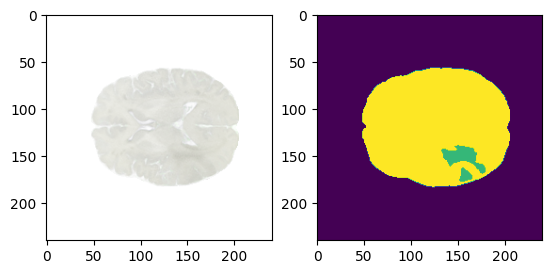

In [16]:
vnum = 7
fig, ax = plt.subplots(1,2)
ax[0].imshow(tf.cast(127.5*(val_images[vnum]+1), 'uint8'))
ax[1].imshow(val_masks[vnum])

In [17]:
# Calculate class weights
weights = 1.0/np.array(pixel_counts)
weights = weights/np.sum(weights)

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  #class_weights = tf.constant([2.0, 2.0, 1.0])
  #class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [18]:
# Define convolution layer steps
initializer = tf.random_normal_initializer(0., 0.02)

def horizontal_convolution(input, num_filters, activation='relu', dropout_rate=0.0):
    
    x = tf.keras.layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        padding= 'same',
        strides=1,
        kernel_initializer=initializer,
        use_bias=False,
    )(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.Activation(activation=activation)(x) 
    return x


def down_step(input, num_filters, dropout_rate=0.0):
    x = horizontal_convolution(
        input=input,
        num_filters=num_filters,
        dropout_rate=dropout_rate,
    )
    horizontal_out = horizontal_convolution(
        x, 
        num_filters=num_filters,
        dropout_rate=dropout_rate,
    )
    down_out = tf.keras.layers.MaxPooling2D(
        pool_size=2,
        strides=2, 
        padding = 'same'
    )(horizontal_out)
    return down_out, horizontal_out


def up_step(
    up_input, 
    horizontal_input, 
    num_filters, 
    dropout_rate=0.0, 
):
    x = tf.keras.layers.Conv2DTranspose(
        filters=num_filters,
        kernel_size=3, 
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False,
    )(up_input)
    x = tf.keras.layers.Concatenate()([x, horizontal_input])
    x = horizontal_convolution(
        x, 
        num_filters=num_filters, 
        dropout_rate=dropout_rate
    )
    x = horizontal_convolution(
        x, 
        num_filters=num_filters, 
        dropout_rate=dropout_rate,
        activation='softmax',
    )
    return x

In [19]:
# Define U-Net topology
def unet(
    input_shape, 
    output_channels, 
    scale_filters=1.0, 
    dropout_rate=0.0,
    final_dropout=True
    ):

    final_dropout_rate=0.0
    if final_dropout:
        final_dropout_rate = dropout_rate

    inputs = tf.keras.layers.Input(shape=input_shape)

    down_1, cross_1 = down_step(
        inputs, 
        int(64*scale_filters), 
        dropout_rate=dropout_rate
    )  # 240 -> 120
    down_2, cross_2 = down_step(
        down_1, 
        int(128*scale_filters), 
        dropout_rate=dropout_rate
    )  # 120 -> 60
    down_3, cross_3 = down_step(
        down_2, 
        int(256*scale_filters), 
        dropout_rate=dropout_rate
    )  # 60 -> 30
    down_4, cross_4 = down_step(
        down_3, 
        int(512*scale_filters), 
        dropout_rate=dropout_rate
    )  # 30 -> 15

    bottom = horizontal_convolution(
        down_4, 
        int(1024*scale_filters), 
        dropout_rate=dropout_rate
    )

    up_4 = up_step(
        bottom, 
        cross_4, 
        int(512*scale_filters), 
        dropout_rate=dropout_rate
    )  # 15 -> 30
    up_3 = up_step(
        up_4, 
        cross_3, 
        int(256*scale_filters), 
        dropout_rate=dropout_rate
    )  # 30 -> 60
    up_2 = up_step(
        up_3, 
        cross_2, 
        int(128*scale_filters), 
        dropout_rate=dropout_rate
    )  # 60 -> 120
    up_1 = up_step(
        up_2, 
        cross_1, 
        int(64*scale_filters), 
        dropout_rate=final_dropout_rate
    )  # 120 -> 240
    
    outputs = horizontal_convolution(up_1, output_channels)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [20]:
with strategy.scope():
    input_shape = (img_width,img_height,scan_channels)
    model = unet(
        input_shape=input_shape, 
        output_channels=output_classes, 
        dropout_rate=0.0
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

2022-12-04 00:17:12.571382: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-04 00:17:12.640699: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 64  2304        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

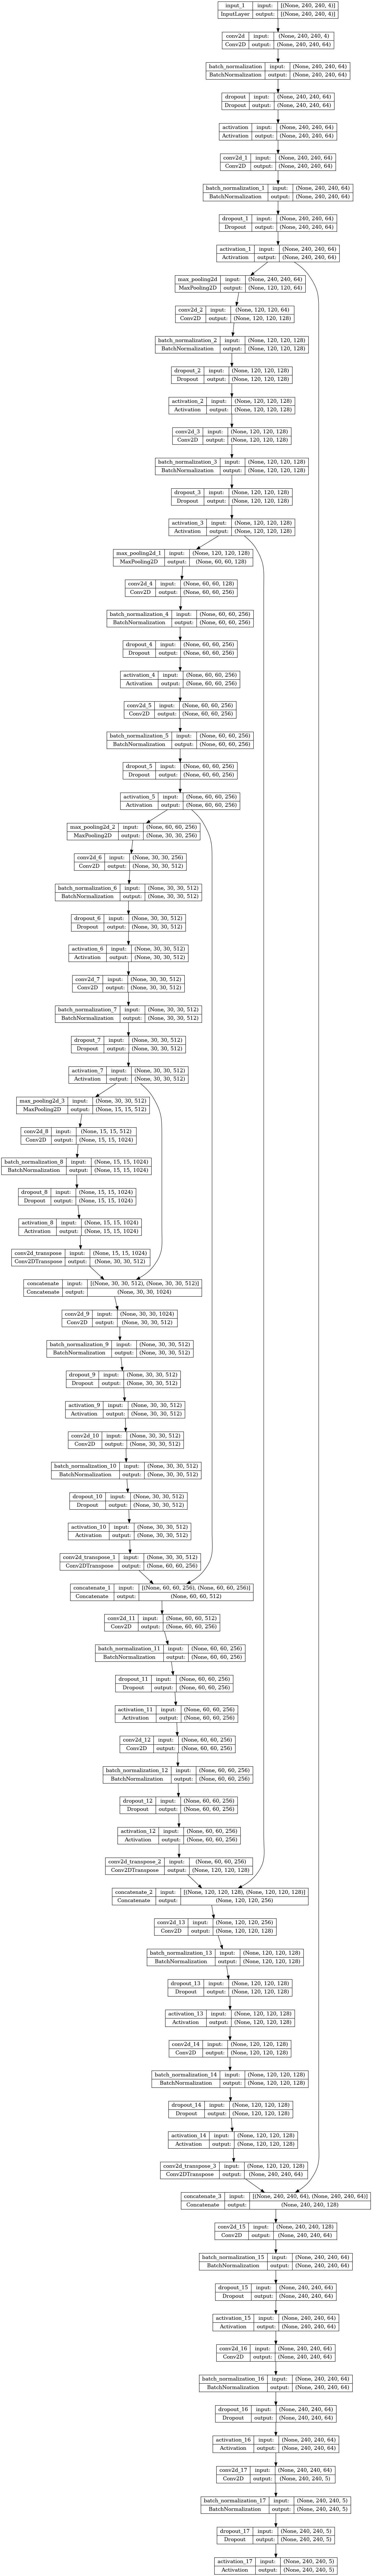

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

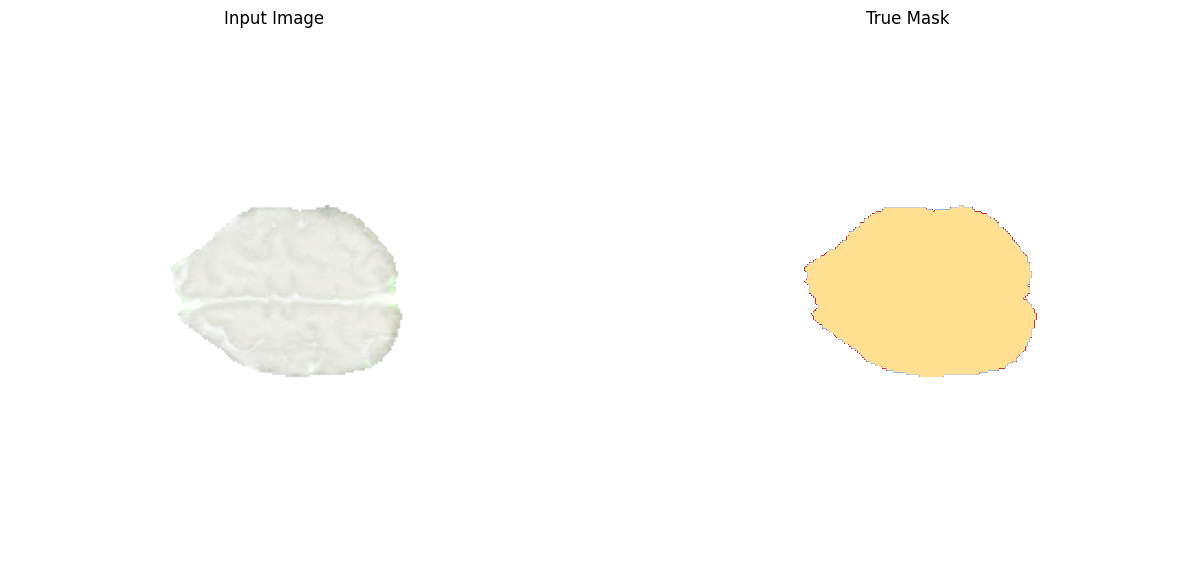

(64, 240, 240, 4) (64, 240, 240, 1)


2022-12-04 00:17:28.740275: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [23]:
for images, masks in train_batch.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])
    print(images.shape, masks.shape)

2022-12-04 00:17:31.306887: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:3842992761621787933
2022-12-04 00:17:31.366561: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-04 00:17:31.475214: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-04 00:17:31.636621: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(7951112255627162456), session_name()


1/1 [==============================] - 11s 11s/step


2022-12-04 00:17:41.516633: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 7951112255627162456 with session name  took 9.87993171s and succeeded
2022-12-04 00:17:41.525029: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(7951112255627162456), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_3842992761621787933", property.function_library_fingerprint = 5091778416241757957, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "2,240,240,4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-04 00:17:41.525069: I tensorflow/core/

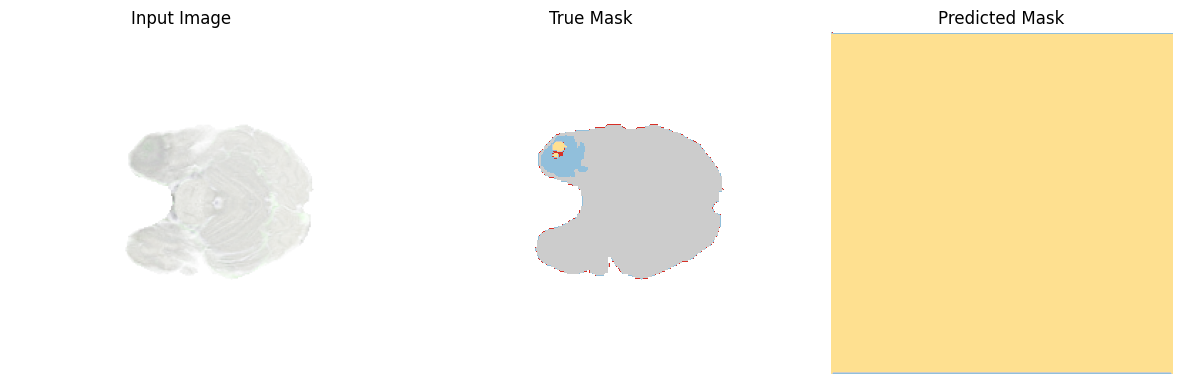

In [24]:
slice_num=17
sample_image, sample_mask = images[slice_num], masks[slice_num]
show_predictions()

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [26]:
earlystopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            )

In [27]:
run_name_params = (
        f'bs64'
        f'_pat10'
        f'_dr0.0'
        f'_lr0.0001'
    )
    
print("Using parameters")
print(run_name_params)
run_name = f'unet_{run_name_params}_scratch'

Using parameters
bs64_pat10_dr0.0_lr0.0001


In [28]:
if not os.path.exists('model_checkpoints'):
    os.mkdir('model_checkpoints')

checkpoint_path = os.path.join(
    'model_checkpoints',
    run_name + start_time + "-{epoch:03d}-{val_loss:.4f}.ckpt"
)
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=False,
    save_freq='epoch',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

In [29]:
print(len(train_image_filepaths),len(val_image_filepaths))

61772 15443


2022-12-04 00:17:42.507117: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 61772
  }
}
attr {
  key: "is_files"
  value {
    b: true
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 1/100


2022-12-04 00:17:51.475417: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:15973223919864966164
2022-12-04 00:17:51.834259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-04 00:17:52.105502: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-04 00:17:53.202527: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(11380775318426585846), session_name()
2022-12-04 00:19:22.297506: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 11380775318426585846 with session name  took 1m29.094871942s and succeeded
2022-12-04 00:19:22.343908: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU h

965/965 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9133

2022-12-04 00:24:34.386697: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 15443
  }
}
attr {
  key: "is_files"
  value {
    b: true
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:3"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-12-04 

1/1 [==============================] - 0s 489ms/step


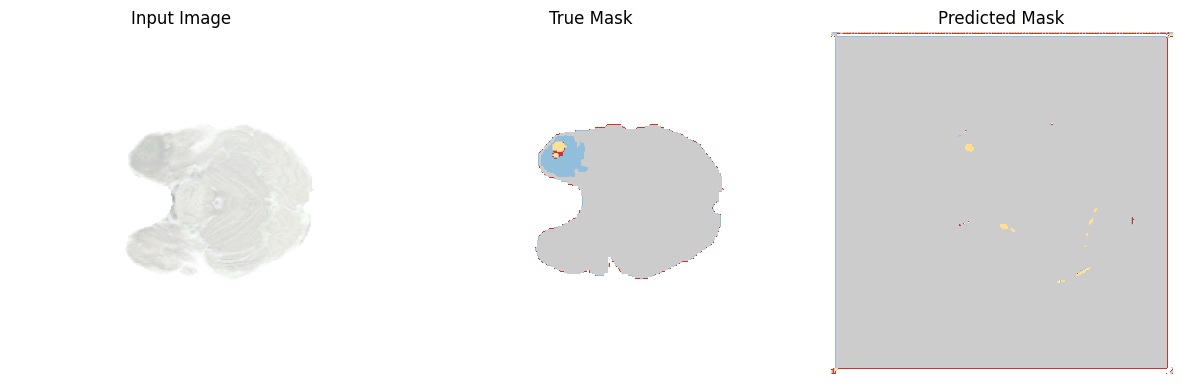


Sample Prediction after epoch 1


Epoch 1: val_loss improved from inf to 1.41371, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-001-1.4137.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-001-1.4137.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-001-1.4137.ckpt/assets


965/965 [==============================] - 515s 432ms/step - loss: 0.0024 - accuracy: 0.9133 - val_loss: 1.4137 - val_accuracy: 0.2280
Epoch 2/100
1/1 [==============================] - 0s 495ms/step loss: 0.0017 - accuracy: 0.94


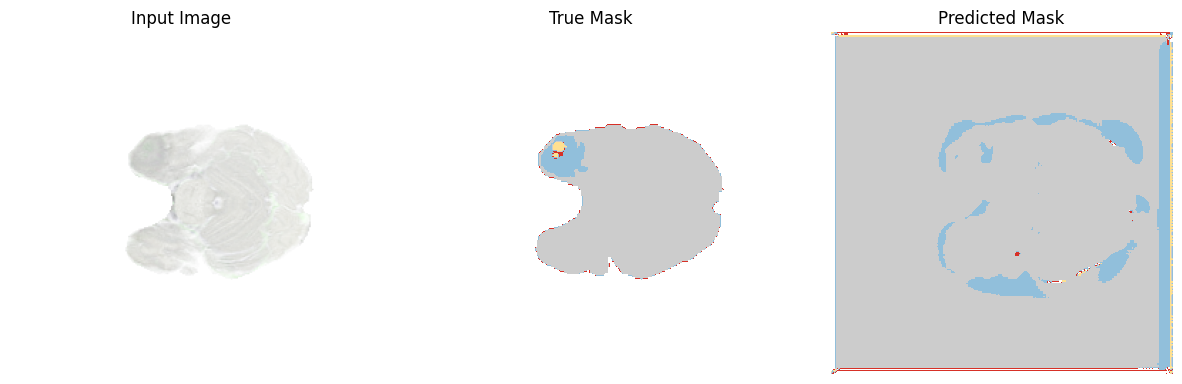


Sample Prediction after epoch 2


Epoch 2: val_loss did not improve from 1.41371
965/965 [==============================] - 341s 354ms/step - loss: 0.0017 - accuracy: 0.9455 - val_loss: 1.4558 - val_accuracy: 0.1800
Epoch 3/100
1/1 [==============================] - 0s 469ms/step loss: 0.0015 - accuracy: 0.96


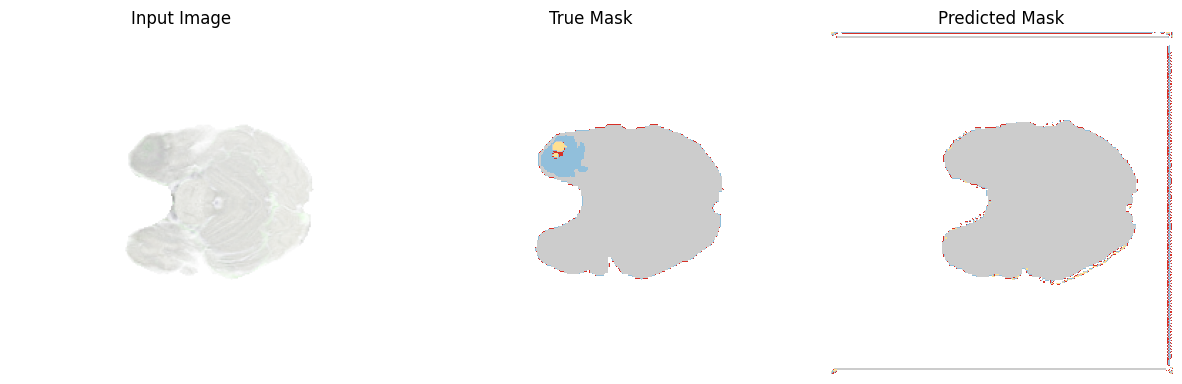


Sample Prediction after epoch 3


Epoch 3: val_loss improved from 1.41371 to 1.00189, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-003-1.0019.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-003-1.0019.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-003-1.0019.ckpt/assets


965/965 [==============================] - 351s 364ms/step - loss: 0.0015 - accuracy: 0.9617 - val_loss: 1.0019 - val_accuracy: 0.9536
Epoch 4/100
1/1 [==============================] - 0s 488ms/step loss: 0.0013 - accuracy: 0.97


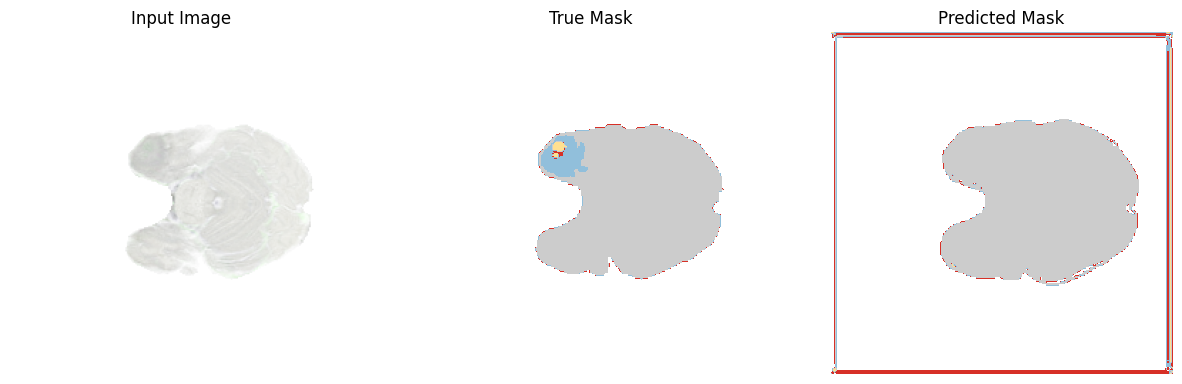


Sample Prediction after epoch 4


Epoch 4: val_loss did not improve from 1.00189
965/965 [==============================] - 340s 352ms/step - loss: 0.0013 - accuracy: 0.9703 - val_loss: 1.1024 - val_accuracy: 0.9093
Epoch 5/100
1/1 [==============================] - 0s 464ms/step loss: 0.0012 - accuracy: 0.97


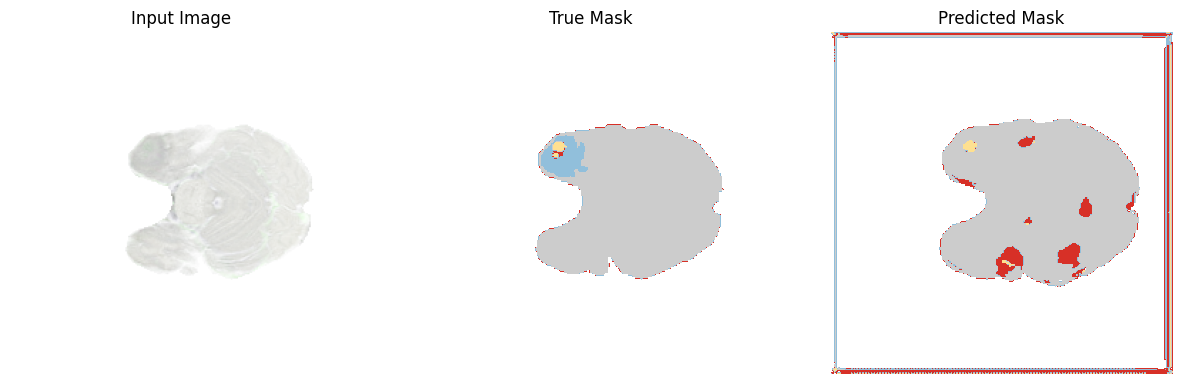


Sample Prediction after epoch 5


Epoch 5: val_loss did not improve from 1.00189
965/965 [==============================] - 340s 352ms/step - loss: 0.0012 - accuracy: 0.9762 - val_loss: 1.1800 - val_accuracy: 0.8842
Epoch 6/100
1/1 [==============================] - 0s 457ms/step loss: 0.0011 - accuracy: 0.98


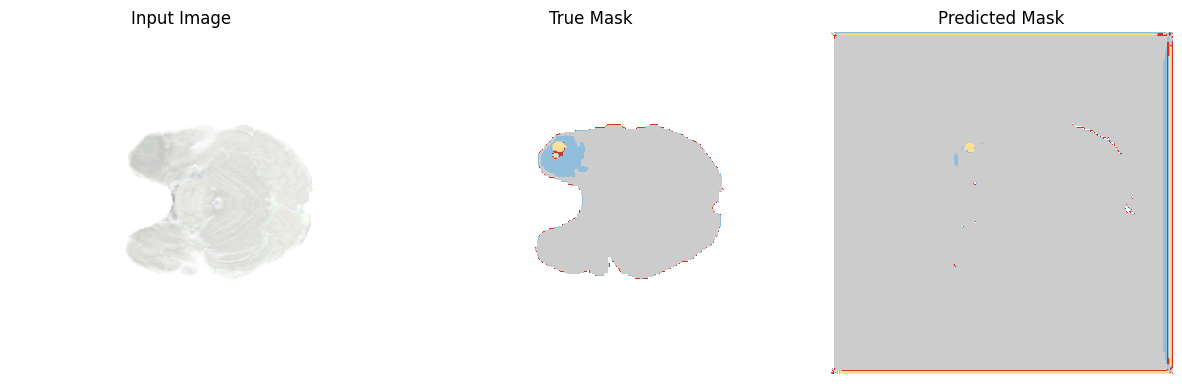


Sample Prediction after epoch 6


Epoch 6: val_loss did not improve from 1.00189
965/965 [==============================] - 339s 351ms/step - loss: 0.0011 - accuracy: 0.9802 - val_loss: 1.3845 - val_accuracy: 0.1906
Epoch 7/100
1/1 [==============================] - 0s 464ms/step loss: 9.9712e-04 - accuracy: 0.98


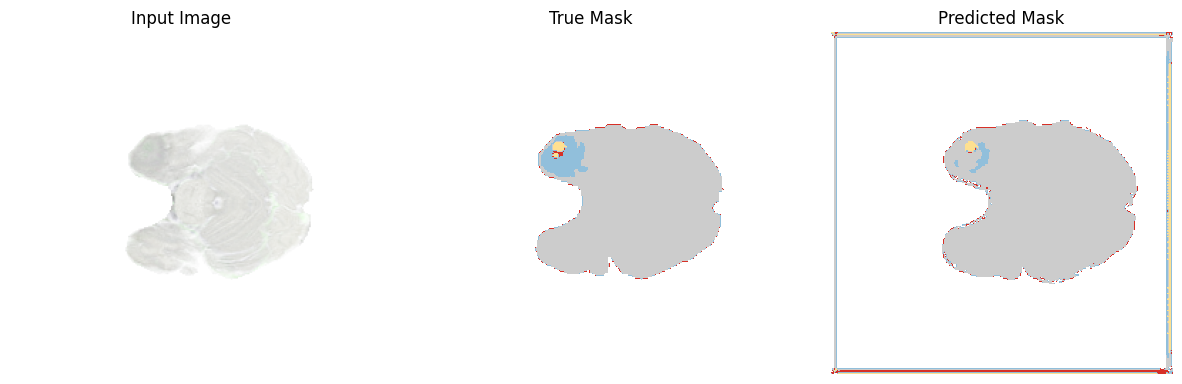


Sample Prediction after epoch 7


Epoch 7: val_loss improved from 1.00189 to 0.95322, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-007-0.9532.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-007-0.9532.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-007-0.9532.ckpt/assets


965/965 [==============================] - 351s 363ms/step - loss: 9.9712e-04 - accuracy: 0.9825 - val_loss: 0.9532 - val_accuracy: 0.9205
Epoch 8/100
1/1 [==============================] - 0s 481ms/step loss: 9.2776e-04 - accuracy: 0.98


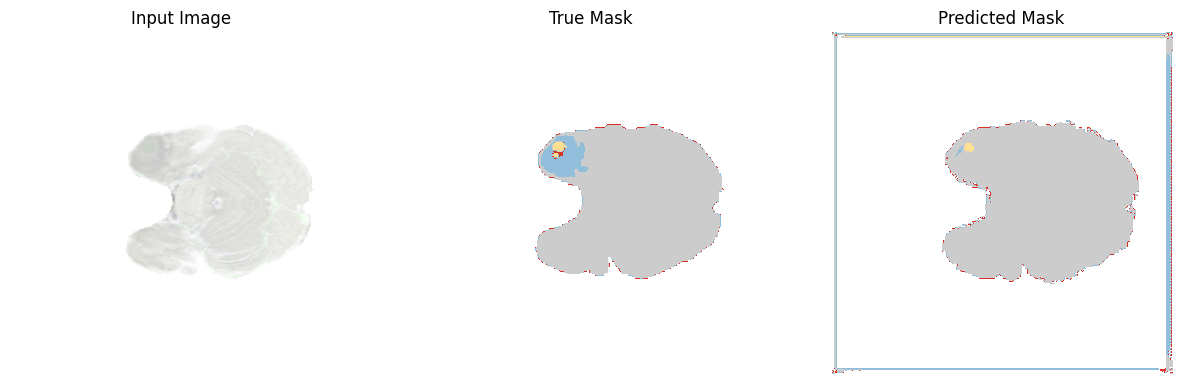


Sample Prediction after epoch 8


Epoch 8: val_loss did not improve from 0.95322
965/965 [==============================] - 340s 352ms/step - loss: 9.2776e-04 - accuracy: 0.9835 - val_loss: 0.9967 - val_accuracy: 0.9363
Epoch 9/100
1/1 [==============================] - 0s 474ms/step loss: 8.5378e-04 - accuracy: 0.98


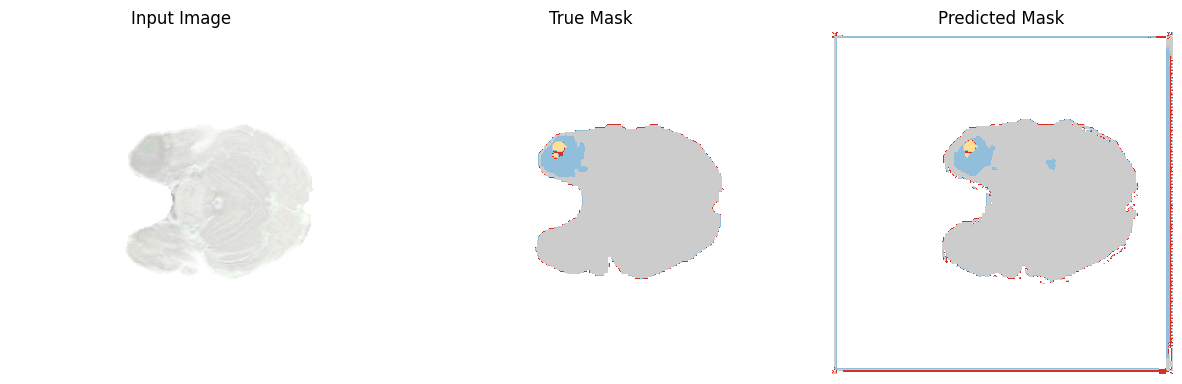


Sample Prediction after epoch 9


Epoch 9: val_loss did not improve from 0.95322
965/965 [==============================] - 340s 353ms/step - loss: 8.5378e-04 - accuracy: 0.9838 - val_loss: 0.9580 - val_accuracy: 0.9272
Epoch 10/100
1/1 [==============================] - 0s 476ms/step loss: 7.9545e-04 - accuracy: 0.98


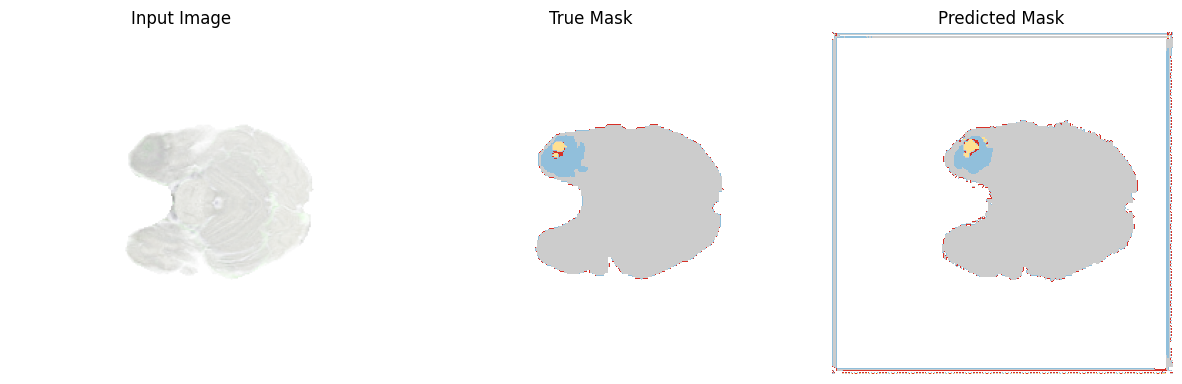


Sample Prediction after epoch 10


Epoch 10: val_loss improved from 0.95322 to 0.86922, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-010-0.8692.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-010-0.8692.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-010-0.8692.ckpt/assets


965/965 [==============================] - 351s 364ms/step - loss: 7.9545e-04 - accuracy: 0.9837 - val_loss: 0.8692 - val_accuracy: 0.9358
Epoch 11/100
1/1 [==============================] - 0s 473ms/step loss: 7.4183e-04 - accuracy: 0.98


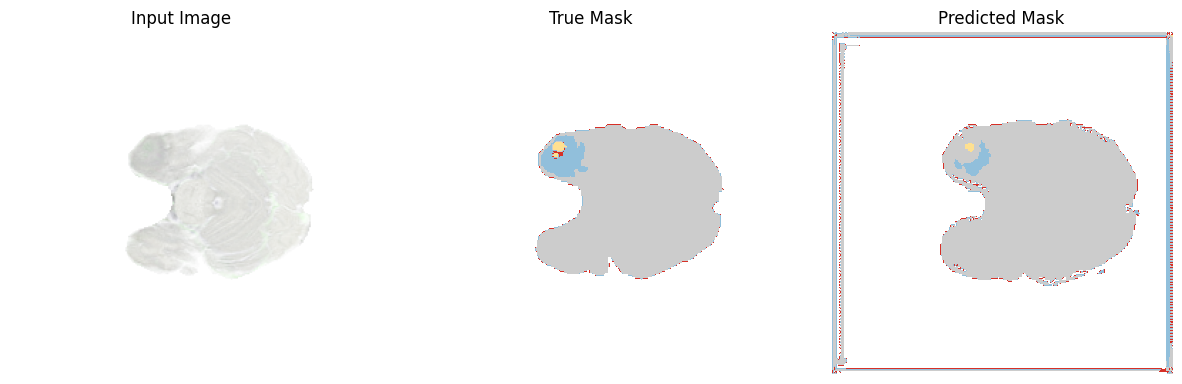


Sample Prediction after epoch 11


Epoch 11: val_loss did not improve from 0.86922
965/965 [==============================] - 340s 352ms/step - loss: 7.4183e-04 - accuracy: 0.9843 - val_loss: 0.9503 - val_accuracy: 0.9006
Epoch 12/100
1/1 [==============================] - 0s 470ms/step loss: 6.9381e-04 - accuracy: 0.98


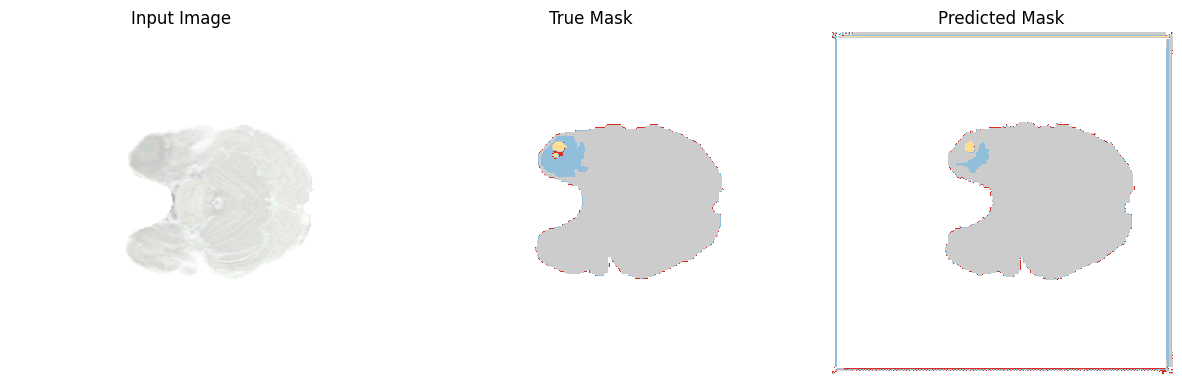


Sample Prediction after epoch 12


Epoch 12: val_loss improved from 0.86922 to 0.52770, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-012-0.5277.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-012-0.5277.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-012-0.5277.ckpt/assets


965/965 [==============================] - 351s 363ms/step - loss: 6.9381e-04 - accuracy: 0.9853 - val_loss: 0.5277 - val_accuracy: 0.9433
Epoch 13/100
1/1 [==============================] - 0s 475ms/step loss: 6.4103e-04 - accuracy: 0.98


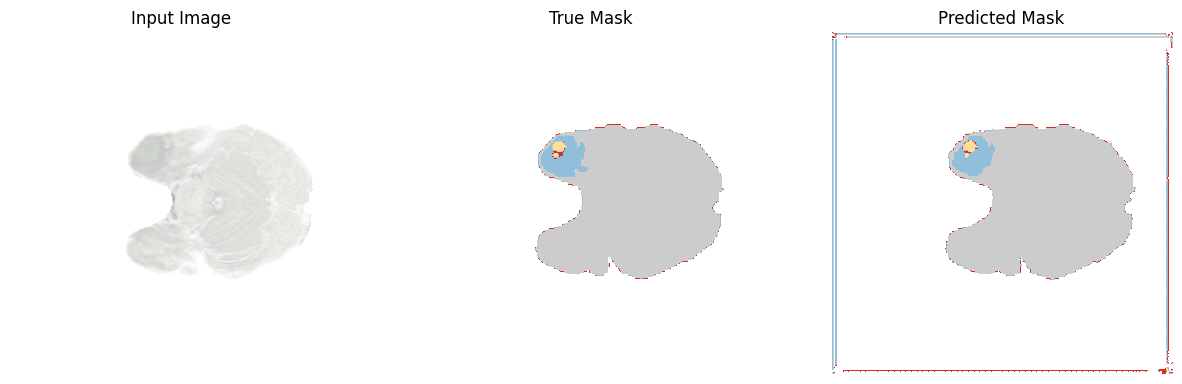


Sample Prediction after epoch 13


Epoch 13: val_loss improved from 0.52770 to 0.38106, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-013-0.3811.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-013-0.3811.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-013-0.3811.ckpt/assets


965/965 [==============================] - 352s 364ms/step - loss: 6.4103e-04 - accuracy: 0.9876 - val_loss: 0.3811 - val_accuracy: 0.9636
Epoch 14/100
1/1 [==============================] - 0s 469ms/step loss: 6.0076e-04 - accuracy: 0.98


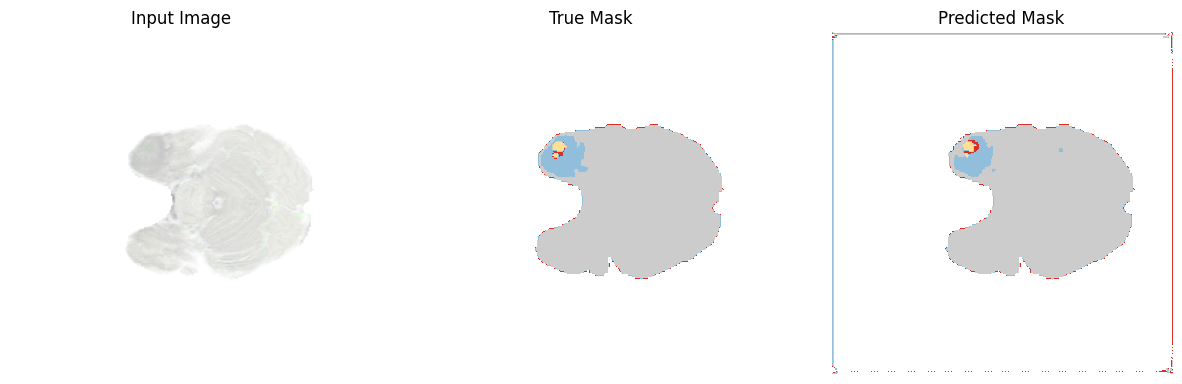


Sample Prediction after epoch 14


Epoch 14: val_loss improved from 0.38106 to 0.32736, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-014-0.3274.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-014-0.3274.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-014-0.3274.ckpt/assets


965/965 [==============================] - 351s 364ms/step - loss: 6.0076e-04 - accuracy: 0.9890 - val_loss: 0.3274 - val_accuracy: 0.9798
Epoch 15/100
1/1 [==============================] - 0s 469ms/step loss: 5.6918e-04 - accuracy: 0.98


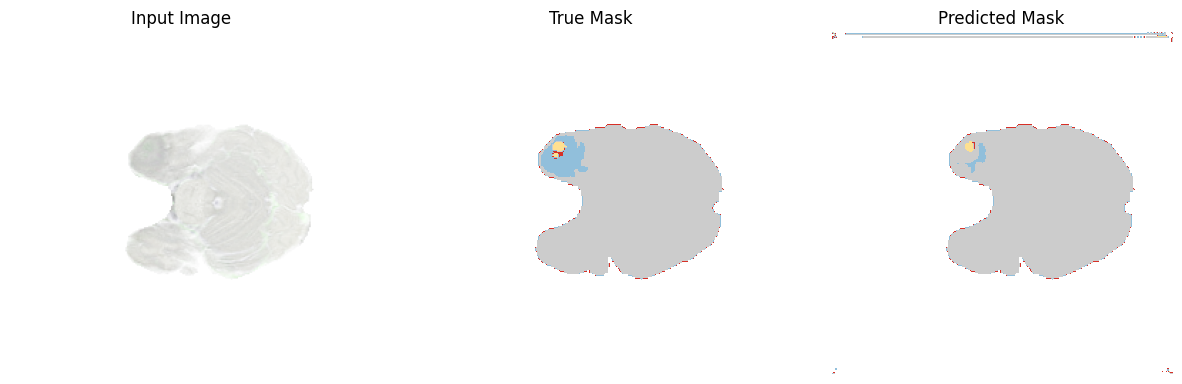


Sample Prediction after epoch 15


Epoch 15: val_loss improved from 0.32736 to 0.28701, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-015-0.2870.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-015-0.2870.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-015-0.2870.ckpt/assets


965/965 [==============================] - 351s 364ms/step - loss: 5.6918e-04 - accuracy: 0.9897 - val_loss: 0.2870 - val_accuracy: 0.9889
Epoch 16/100
1/1 [==============================] - 0s 461ms/step loss: 5.3634e-04 - accuracy: 0.99


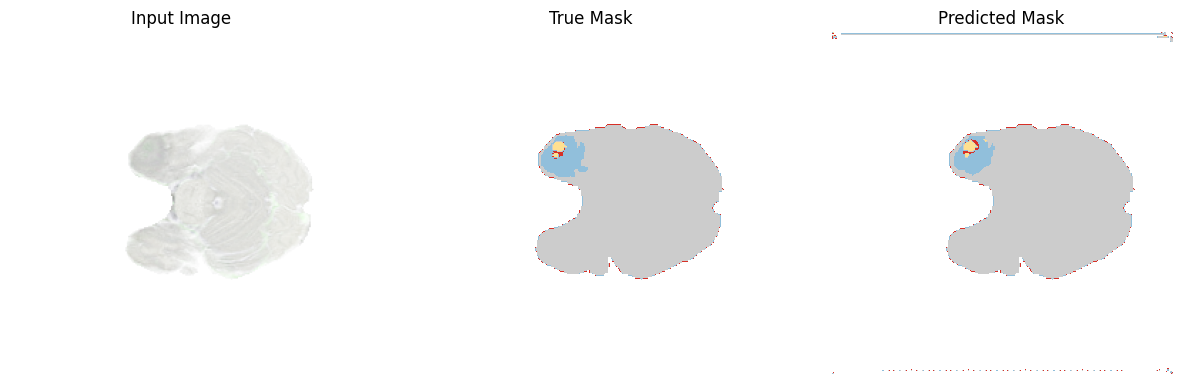


Sample Prediction after epoch 16


Epoch 16: val_loss improved from 0.28701 to 0.26172, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-016-0.2617.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-016-0.2617.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-016-0.2617.ckpt/assets


965/965 [==============================] - 351s 364ms/step - loss: 5.3634e-04 - accuracy: 0.9906 - val_loss: 0.2617 - val_accuracy: 0.9903
Epoch 17/100
1/1 [==============================] - 0s 492ms/step loss: 5.1468e-04 - accuracy: 0.99


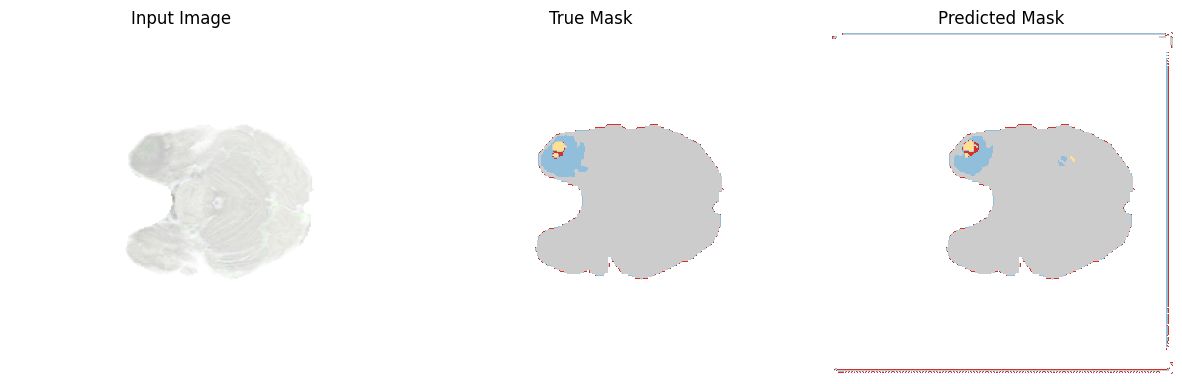


Sample Prediction after epoch 17


Epoch 17: val_loss did not improve from 0.26172
965/965 [==============================] - 340s 353ms/step - loss: 5.1468e-04 - accuracy: 0.9909 - val_loss: 0.2658 - val_accuracy: 0.9747
Epoch 18/100
1/1 [==============================] - 1s 512ms/step loss: 4.8196e-04 - accuracy: 0.99


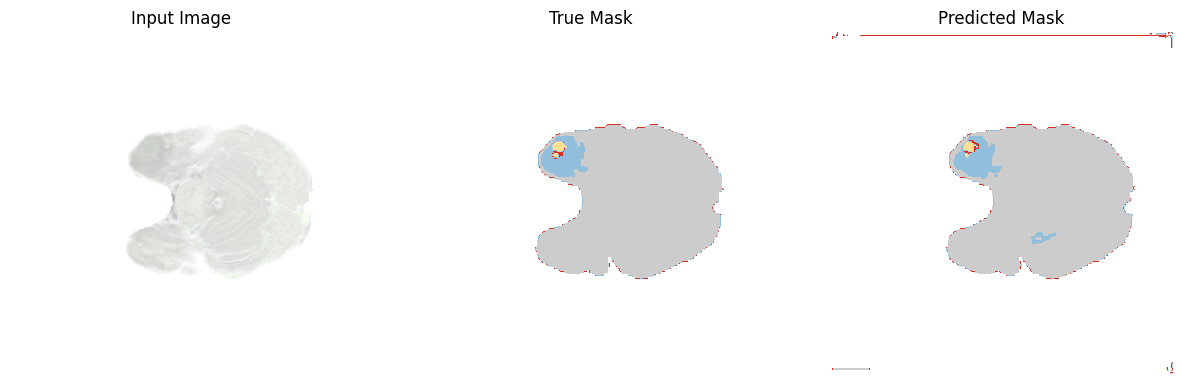


Sample Prediction after epoch 18


Epoch 18: val_loss improved from 0.26172 to 0.24592, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-018-0.2459.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-018-0.2459.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-018-0.2459.ckpt/assets


965/965 [==============================] - 351s 364ms/step - loss: 4.8196e-04 - accuracy: 0.9919 - val_loss: 0.2459 - val_accuracy: 0.9895
Epoch 19/100
1/1 [==============================] - 0s 471ms/step loss: 4.5615e-04 - accuracy: 0.99


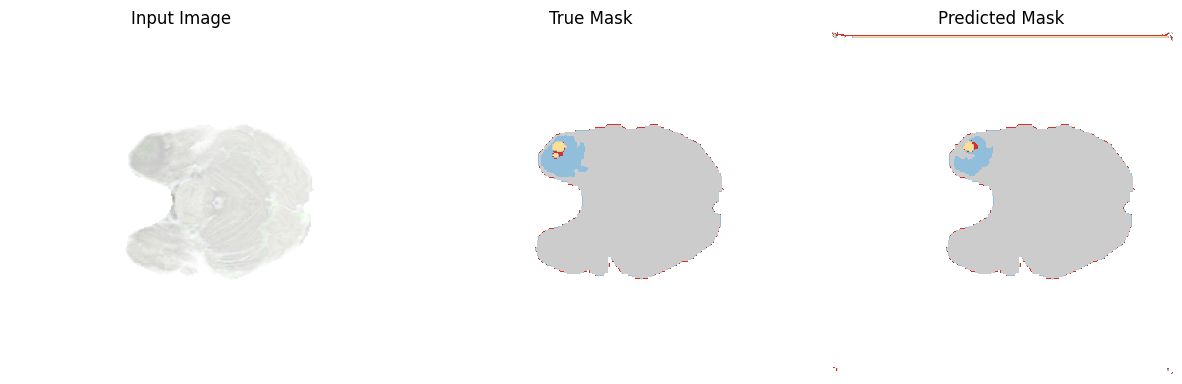


Sample Prediction after epoch 19


Epoch 19: val_loss improved from 0.24592 to 0.24019, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-019-0.2402.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-019-0.2402.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-019-0.2402.ckpt/assets


965/965 [==============================] - 352s 365ms/step - loss: 4.5615e-04 - accuracy: 0.9926 - val_loss: 0.2402 - val_accuracy: 0.9867
Epoch 20/100
1/1 [==============================] - 0s 486ms/step loss: 4.2735e-04 - accuracy: 0.99


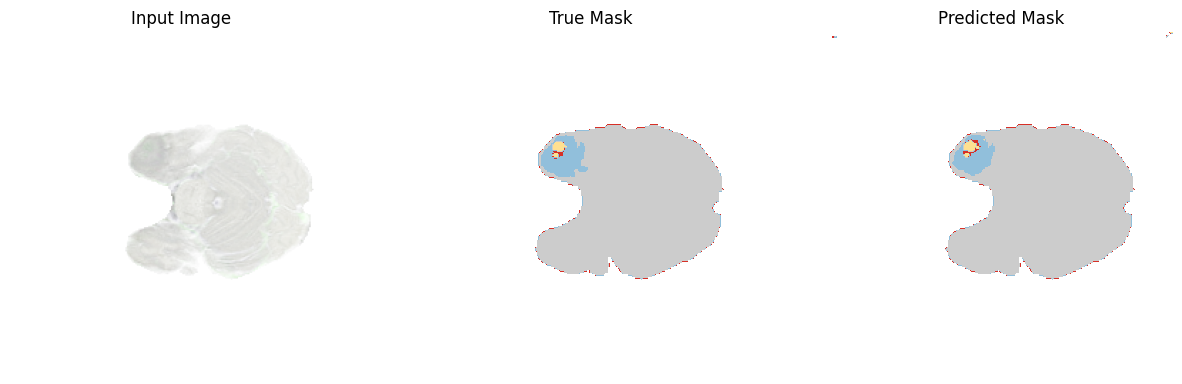


Sample Prediction after epoch 20


Epoch 20: val_loss improved from 0.24019 to 0.16381, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-020-0.1638.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-020-0.1638.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-020-0.1638.ckpt/assets


965/965 [==============================] - 351s 364ms/step - loss: 4.2735e-04 - accuracy: 0.9929 - val_loss: 0.1638 - val_accuracy: 0.9949
Epoch 21/100
1/1 [==============================] - 1s 1s/steps - loss: 3.8478e-04 - accuracy: 0.99


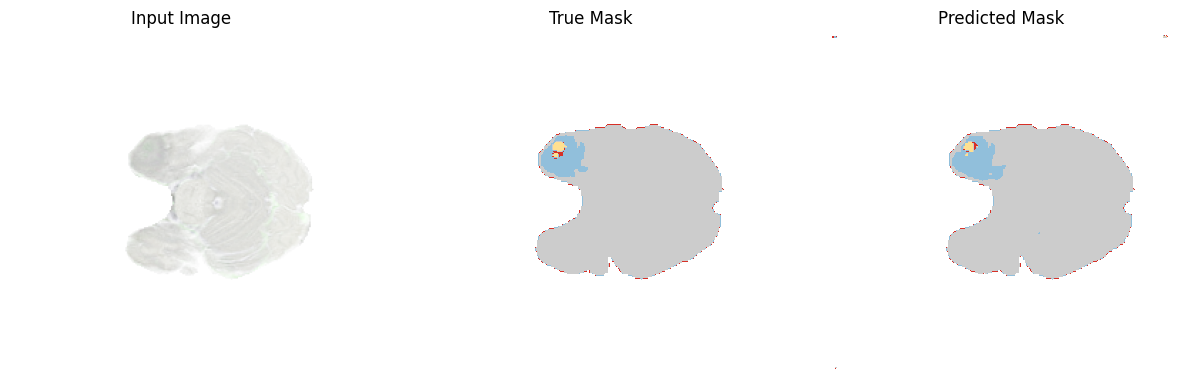


Sample Prediction after epoch 21


Epoch 21: val_loss did not improve from 0.16381
965/965 [==============================] - 341s 353ms/step - loss: 3.8478e-04 - accuracy: 0.9946 - val_loss: 0.2057 - val_accuracy: 0.9934
Epoch 22/100
1/1 [==============================] - 0s 498ms/step loss: 3.5920e-04 - accuracy: 0.99


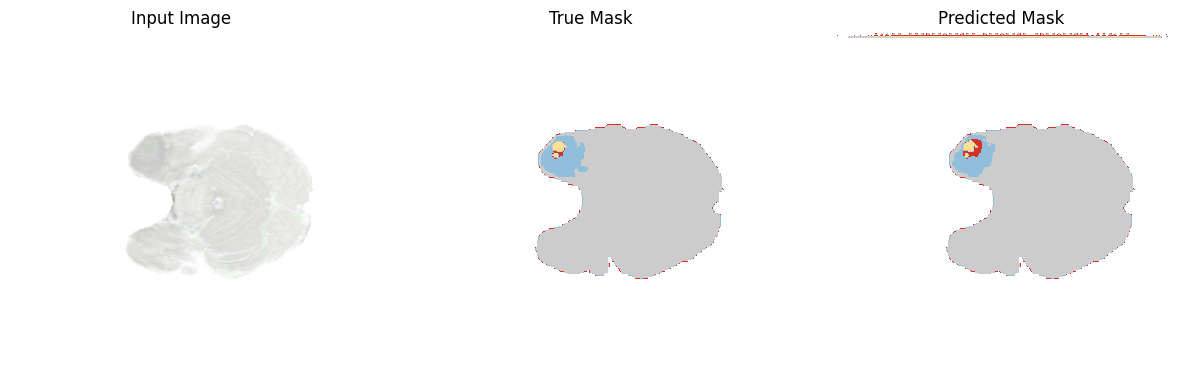


Sample Prediction after epoch 22


Epoch 22: val_loss did not improve from 0.16381
965/965 [==============================] - 339s 351ms/step - loss: 3.5920e-04 - accuracy: 0.9949 - val_loss: 0.1654 - val_accuracy: 0.9889
Epoch 23/100
1/1 [==============================] - 0s 492ms/step loss: 3.2959e-04 - accuracy: 0.99


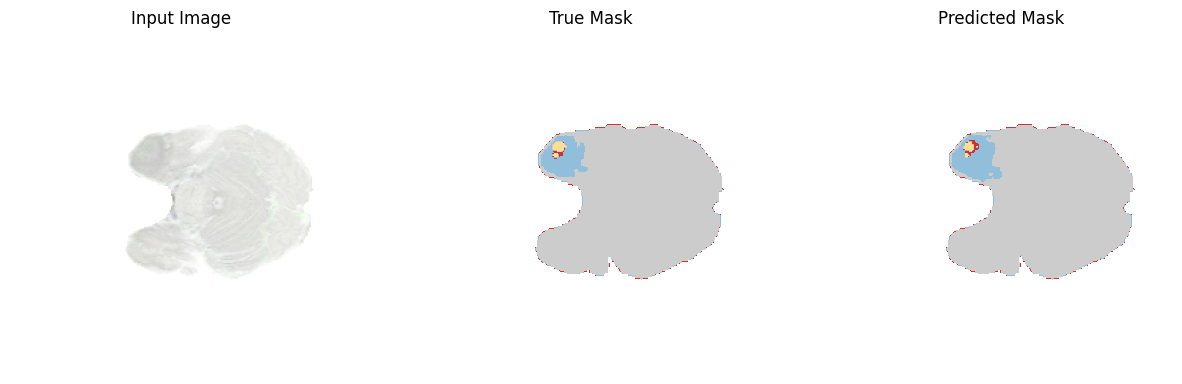


Sample Prediction after epoch 23


Epoch 23: val_loss did not improve from 0.16381
965/965 [==============================] - 339s 351ms/step - loss: 3.2959e-04 - accuracy: 0.9957 - val_loss: 0.1679 - val_accuracy: 0.9956
Epoch 24/100
1/1 [==============================] - 1s 501ms/step loss: 3.0400e-04 - accuracy: 0.99


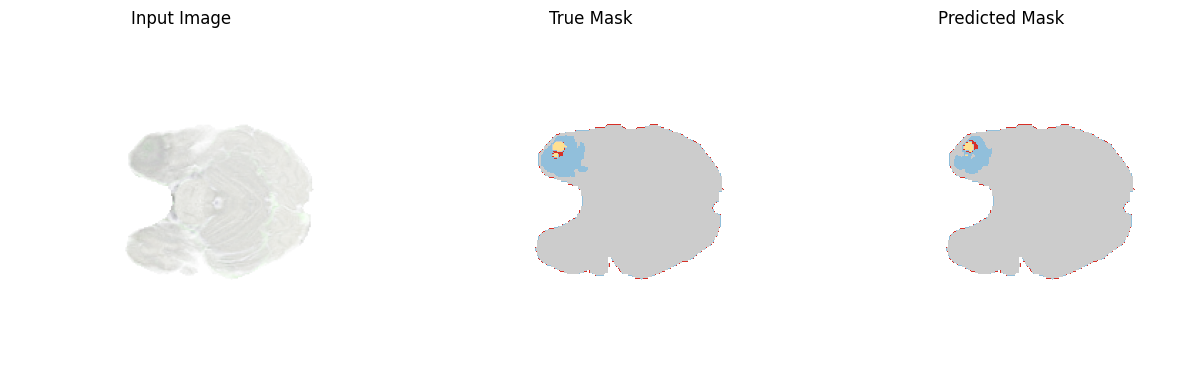


Sample Prediction after epoch 24


Epoch 24: val_loss improved from 0.16381 to 0.12332, saving model to model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-024-0.1233.ckpt


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-024-0.1233.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoints/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54-024-0.1233.ckpt/assets


965/965 [==============================] - 351s 364ms/step - loss: 3.0400e-04 - accuracy: 0.9961 - val_loss: 0.1233 - val_accuracy: 0.9955
Epoch 25/100
1/1 [==============================] - 0s 494ms/step loss: 2.9009e-04 - accuracy: 0.99


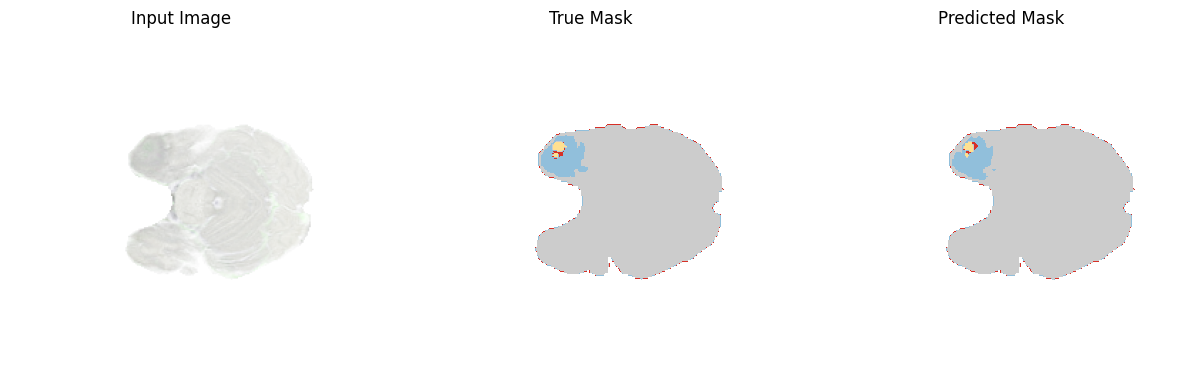


Sample Prediction after epoch 25


Epoch 25: val_loss did not improve from 0.12332
965/965 [==============================] - 341s 353ms/step - loss: 2.9009e-04 - accuracy: 0.9962 - val_loss: 0.1596 - val_accuracy: 0.9956
Epoch 26/100
1/1 [==============================] - 0s 478ms/step loss: 2.7794e-04 - accuracy: 0.99


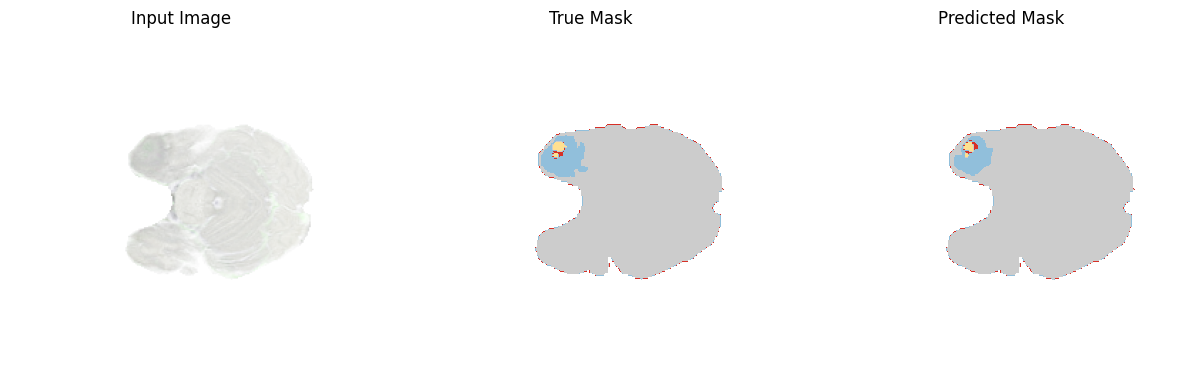


Sample Prediction after epoch 26


Epoch 26: val_loss did not improve from 0.12332
965/965 [==============================] - 341s 353ms/step - loss: 2.7794e-04 - accuracy: 0.9963 - val_loss: 0.1360 - val_accuracy: 0.9952
Epoch 27/100
1/1 [==============================] - 1s 508ms/step loss: 2.7533e-04 - accuracy: 0.99


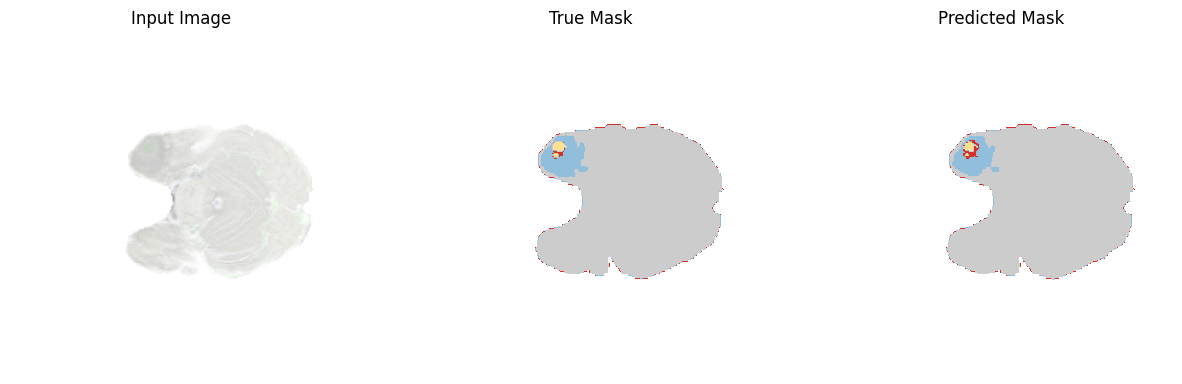


Sample Prediction after epoch 27


Epoch 27: val_loss did not improve from 0.12332
965/965 [==============================] - 340s 353ms/step - loss: 2.7533e-04 - accuracy: 0.9962 - val_loss: 0.1823 - val_accuracy: 0.9957
Epoch 28/100
1/1 [==============================] - 0s 472ms/step loss: 2.5716e-04 - accuracy: 0.99


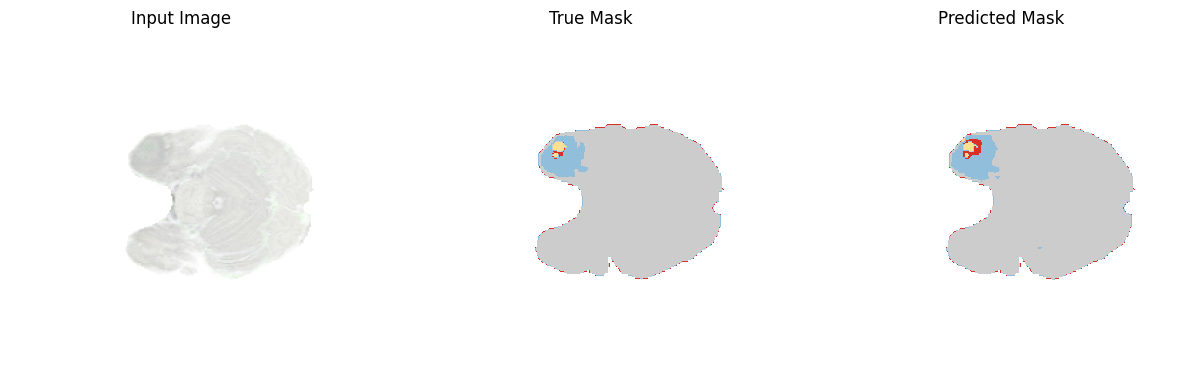


Sample Prediction after epoch 28


Epoch 28: val_loss did not improve from 0.12332
965/965 [==============================] - 340s 352ms/step - loss: 2.5716e-04 - accuracy: 0.9963 - val_loss: 0.1311 - val_accuracy: 0.9954
Epoch 29/100
1/1 [==============================] - 0s 477ms/step loss: 2.4999e-04 - accuracy: 0.99


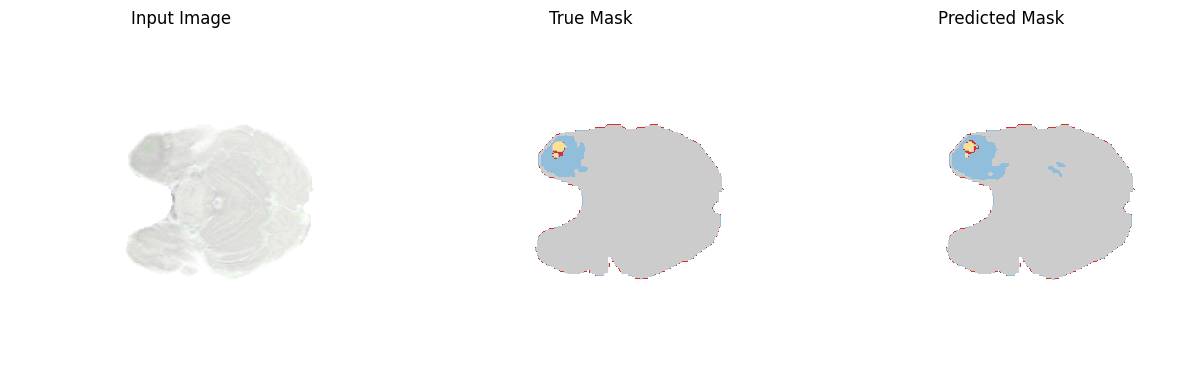


Sample Prediction after epoch 29


Epoch 29: val_loss did not improve from 0.12332
965/965 [==============================] - 340s 352ms/step - loss: 2.4999e-04 - accuracy: 0.9964 - val_loss: 0.3069 - val_accuracy: 0.9946
Epoch 30/100
1/1 [==============================] - 0s 481ms/step loss: 2.3951e-04 - accuracy: 0.99


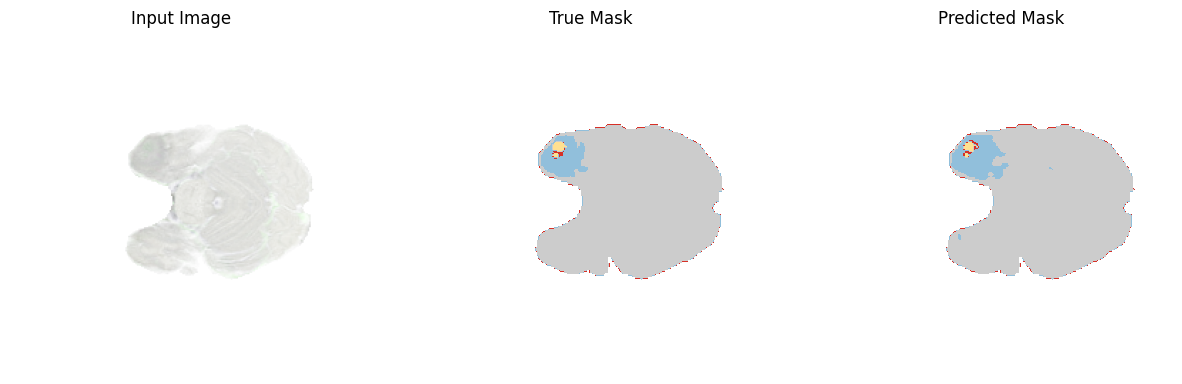


Sample Prediction after epoch 30


Epoch 30: val_loss did not improve from 0.12332
965/965 [==============================] - 339s 351ms/step - loss: 2.3951e-04 - accuracy: 0.9964 - val_loss: 0.3373 - val_accuracy: 0.9937
Epoch 31/100
1/1 [==============================] - 0s 462ms/step loss: 2.3456e-04 - accuracy: 0.99


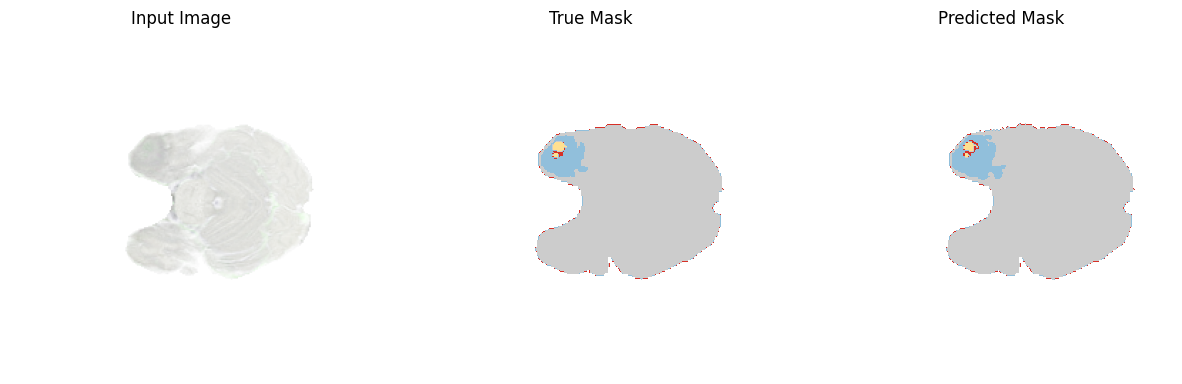


Sample Prediction after epoch 31


Epoch 31: val_loss did not improve from 0.12332
965/965 [==============================] - 340s 352ms/step - loss: 2.3456e-04 - accuracy: 0.9964 - val_loss: 0.2753 - val_accuracy: 0.9952
Epoch 32/100
1/1 [==============================] - 0s 483ms/step loss: 2.2855e-04 - accuracy: 0.99


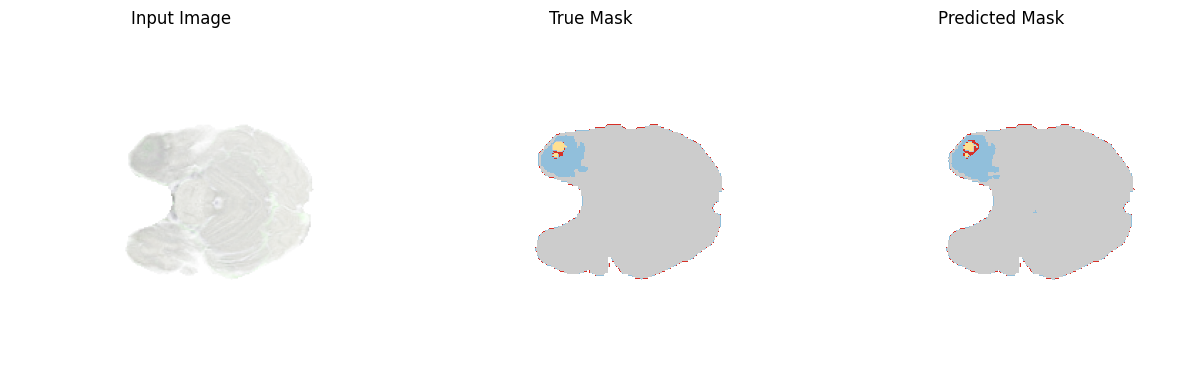


Sample Prediction after epoch 32


Epoch 32: val_loss did not improve from 0.12332
965/965 [==============================] - 339s 352ms/step - loss: 2.2855e-04 - accuracy: 0.9964 - val_loss: 0.1550 - val_accuracy: 0.9946
Epoch 33/100
1/1 [==============================] - 0s 465ms/step loss: 2.2000e-04 - accuracy: 0.99


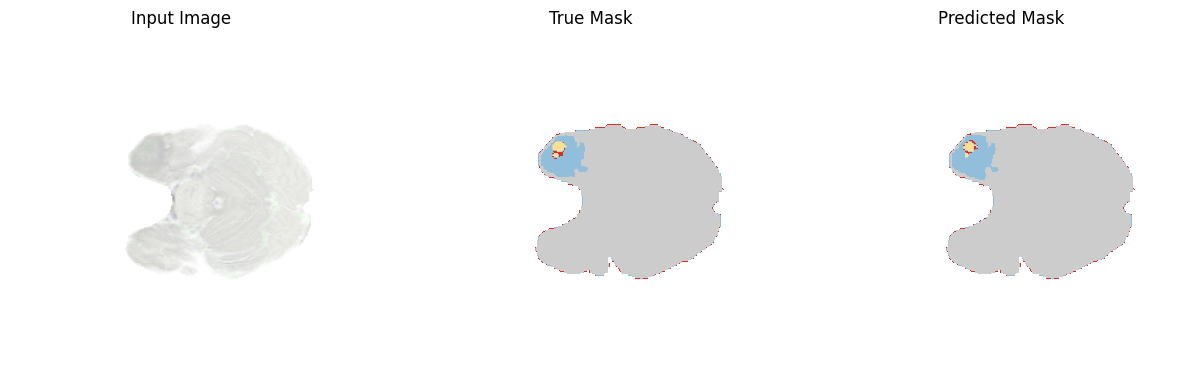


Sample Prediction after epoch 33


Epoch 33: val_loss did not improve from 0.12332
965/965 [==============================] - 339s 351ms/step - loss: 2.2000e-04 - accuracy: 0.9964 - val_loss: 0.1242 - val_accuracy: 0.9953
Epoch 34/100
1/1 [==============================] - 0s 457ms/step loss: 2.1551e-04 - accuracy: 0.99


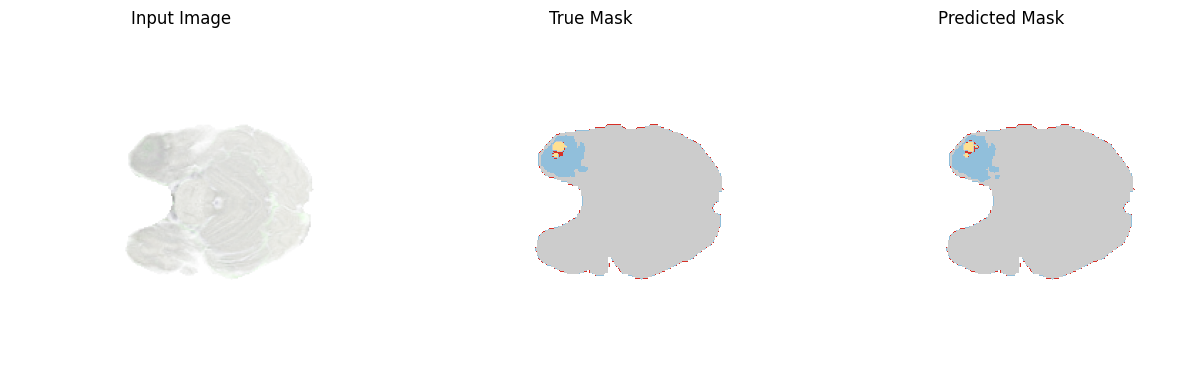


Sample Prediction after epoch 34


Epoch 34: val_loss did not improve from 0.12332
965/965 [==============================] - 338s 351ms/step - loss: 2.1551e-04 - accuracy: 0.9964 - val_loss: 0.1543 - val_accuracy: 0.9957


In [30]:
#lr 0.0001
TRAIN_LENGTH=61772
EPOCHS = 100
VAL_SUBSPLITS = 1
VALIDATION_STEPS = 15443//batch_size//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // batch_size

model_history = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping, ckpt_callback],
)

In [31]:
model_file_name = os.path.join('models', run_name + start_time)
model.save(model_file_name)

INFO:tensorflow:Assets written to: models/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54/assets


INFO:tensorflow:Assets written to: models/unet_bs64_pat10_dr0.0_lr0.0001_scratch-2022-12-04-00:15:54/assets


In [32]:
val_images, val_maps = next(iter(val_batch[0].take(1)))

In [33]:
type(val_maps)

tensorflow.python.framework.ops.EagerTensor

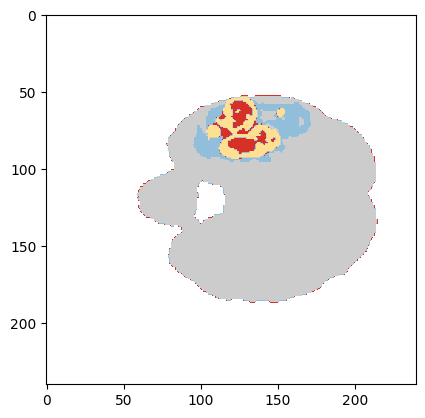

In [34]:
#val_maps.shape
num = 12
plt.imshow(tf.cast(val_maps[num,:,:,0],'uint8'), cmap=cmap)

In [35]:
single_img = tf.expand_dims(val_images[num],0)
single_map = tf.expand_dims(val_maps[num],0)


In [36]:
single_ds = tf.data.Dataset.from_tensor_slices(([single_img],[single_map]))


1/1 [==============================] - 0s 490ms/step


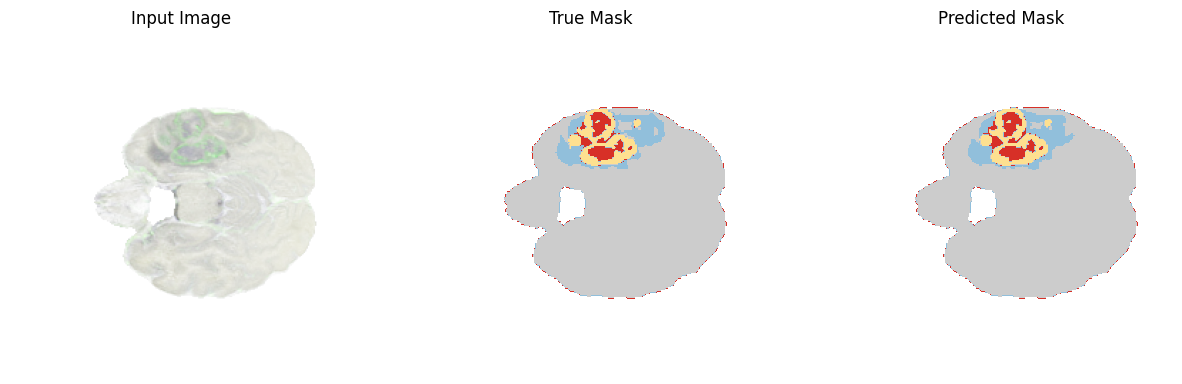

In [37]:
show_predictions(single_ds)

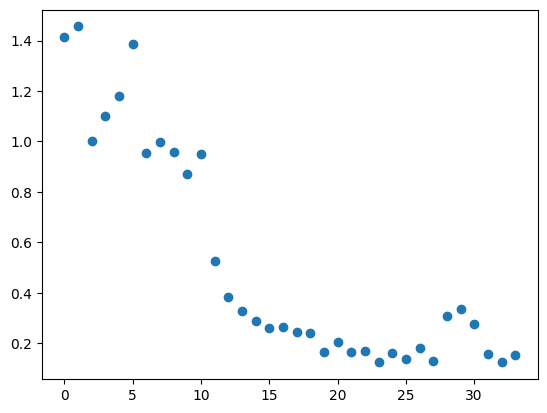

In [42]:
plt.scatter(model_history.epoch,model_history.history['val_loss'])


In [41]:
print(np.min(model_history.history['val_loss']))

0.12332318723201752


In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            )

In [ ]:
# Train layers below layer 100 in down branch
model.layers[4].trainable = True
for layer in model.layers[4].layers[:100]:
    layer.trainable = False


In [ ]:
with strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

In [ ]:
model_history_partialrelax = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=50,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=model_history.epoch[-1]+1,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)

In [ ]:
show_predictions(single_ds)

In [ ]:
# Train all layers
model.trainable = True



In [ ]:
with strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

In [ ]:
VALIDATION_STEPS = 15443//batch_size

In [ ]:
model_history_fullrelax = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=80,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=model_history_partialrelax.epoch[-1]+1,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)